# Import packages for image I/O
In this notebook, we rely on scikit-image for reading and saving images. You need to make it available from Julia.

In [1]:
using PyCall, Printf
import PyPlot
@pyimport skimage.io as io

# Define some functions for image I/O

In [2]:
function imread(filename::String)
    img = io.imread(filename)
    if ndims(img)==3
        img = permutedims(img, (2,3,1))
    end
    return img
end

function imsave(filename::String, img::Array)
    if ndims(img)==3
        img = permutedims(img, (3,1,2))
    end
    io.imsave(filename, img)
end

function visualize3d(img::Array{T,3}, xystep, zstep) where T
    I,J,K = size(img)
    xy = img[:,:,div(K,2)]
    xz = collect(img[div(I,2),:,:]')
    w = xystep * I
    h = xystep * J
    d = zstep * K
    PyPlot.figure(figsize=(12,6))
    PyPlot.subplot(1,2,1)
    PyPlot.imshow(xy, extent=(0,w,0,h), cmap="gray", interpolation=nothing)
    PyPlot.subplot(1,2,2)
    PyPlot.imshow(xz, extent=(0,w,0,d), cmap="gray", interpolation=nothing)
end

visualize3d (generic function with 1 method)

# Load `ThreeDeconv.jl`

In [3]:
using ThreeDeconv

┌ Info: Recompiling stale cache file /home/hayato/.julia/compiled/v1.0/ThreeDeconv/Hlf31.ji for ThreeDeconv [4abe2ffd-29ab-5c0e-9840-7312b59fd2f0]
└ @ Base loading.jl:1184


# For GPU
If you have a NVIDIA GPU, load `CuArrays.jl`. Once you load it, `ThreeDeconv.jl` automatically uses the GPU to perform deconvolution. Even if you don't have it, you can still use `ThreeDeconv.jl` with a CPU.
As I didn't include `CuArrays` as a dependency, you may see a warning but can ignore it.

In [4]:
using CuArrays

┌ Warning: Package ThreeDeconv does not have CuArrays in its dependencies:
│ - If you have ThreeDeconv checked out for development and have
│   added CuArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ThreeDeconv
│ Loading CuArrays into ThreeDeconv from project dependency, future warnings for ThreeDeconv are suppressed.
└ @ nothing nothing:834


# Read a captured image and apply the flatfield correction
You can use the dataset provided on our GitHub repository. Place the images in this `example` directory.

You can also replace the image file to your own images. If your images are captured by a CMOS camera, we expect you to apply a flatfield correction. If your images are captured by a CCD camera, you may be able to just subtract a camera offset from the images before applying deconvolution.

In [5]:
imgraw = imread("dataset/raw/bead/raw_cropped/bead_highsnr_raw.tif")
df = imread("dataset/raw/bead/raw_cropped/df.tif")
ff = imread("dataset/raw/bead/raw_cropped/ff_highsnr.tif")
img = (imgraw .- df) ./ ff;
;

If you downloaded the pre-corrected image, you can comment out the cell below.

In [6]:
# img = imread("dataset/bead/bead_highsnr_ffcor.tif")
;

# Set the microscope setting

In [11]:
obj_mag = 100
camera_pixel_size = 6.5e3 # [nm] after magnifi
xystep = camera_pixel_size / obj_mag
zstep = 150 # [nm]
medium_index = 1.515
f_tubelens = 200.e6
NA = 1.4
λ = 540 # [nm]
;

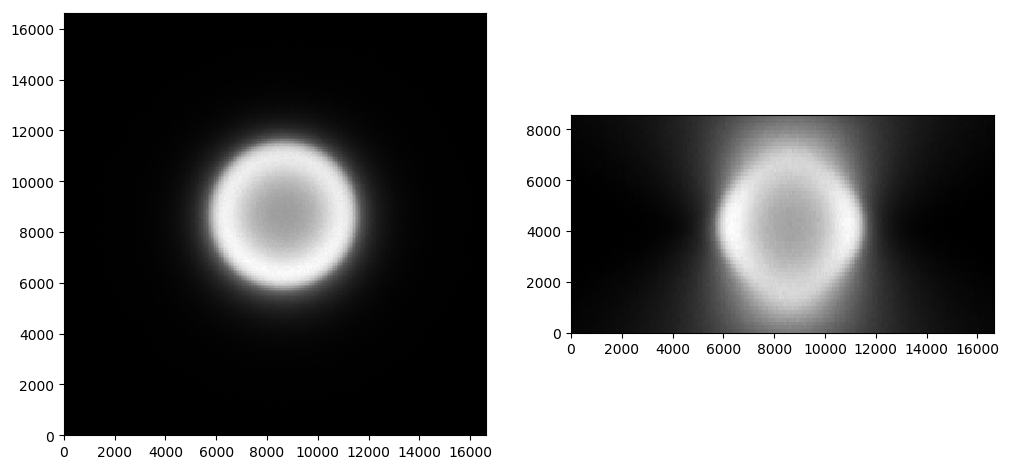

PyObject <matplotlib.image.AxesImage object at 0x7fe3e9b971d0>

In [9]:
visualize3d(img, xystep, zstep)

# Estimate noise parameters from the focal stack image

In [10]:
γ, σ = ThreeDeconv.noise_estimation(img, maxnum_pairs=100)
@printf "Gain: %.1f, Read noise std.: %.1f" γ σ

Computing local noise variance.
Initializing parameters by least-squares.
Initialization done.
Starting likelihood maximization.
Finished the maximization.
Estimated noise parameters are a = 2.315, b = -124.208.
Noise estimation might have failed. σ⁠^2 = -0.188.

                 Proceeding by setting σ^2 = .0 to assure the variance's
                 nonnegativity.
Estimated parameters for Poisson-Gaussian noise model
γ: 2.315075937309712, σ: 1.0e-5
Gain: 2.3, Read noise std.: 0.0

# Simulate a PSF image
Here, we simulate a PSF with a slightly larger size (10px padding along each direction) than the captured image.

In [12]:
pad = 10
psf_shape = size(img).+pad
@show "Simulating PSF with the size of $(psf_shape)"
psf = ThreeDeconv.psf(
    NA = NA,
    objective_mag = obj_mag,
    λ = λ,
    medium_index = medium_index,
    camera_num_pixels = psf_shape[1],
    z_num_pixels = psf_shape[3],
    camera_pixel_size = camera_pixel_size,
    zstep = zstep,
    f_tubelens = f_tubelens,
    oversampling = 4);

"Simulating PSF with the size of $(psf_shape)" = "Simulating PSF with the size of (266, 266, 67)"


MethodError: MethodError: no method matching ThreeDeconv.WaveOptics.WideFieldOpticalRecipe(::Int64, ::Float64, ::Int64, ::Float64, ::Float64)
Closest candidates are:
  ThreeDeconv.WaveOptics.WideFieldOpticalRecipe(::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Any, !Matched::Any, !Matched::Any) at /home/hayato/.julia/dev/ThreeDeconv/src/psf/psf/recipe.jl:87
  ThreeDeconv.WaveOptics.WideFieldOpticalRecipe(::Number, ::Float64, !Matched::Float64, ::Float64, ::Float64; static_aperture_mask, dynamic_aperture_mask, normalize_intensity) at /home/hayato/.julia/dev/ThreeDeconv/src/psf/psf/recipe.jl:132
  ThreeDeconv.WaveOptics.WideFieldOpticalRecipe(!Matched::Float64, ::Float64, !Matched::Float64, ::Float64, ::Float64, !Matched::Float64, !Matched::Any, !Matched::Any, !Matched::Bool) at /home/hayato/.julia/dev/ThreeDeconv/src/psf/psf/recipe.jl:87

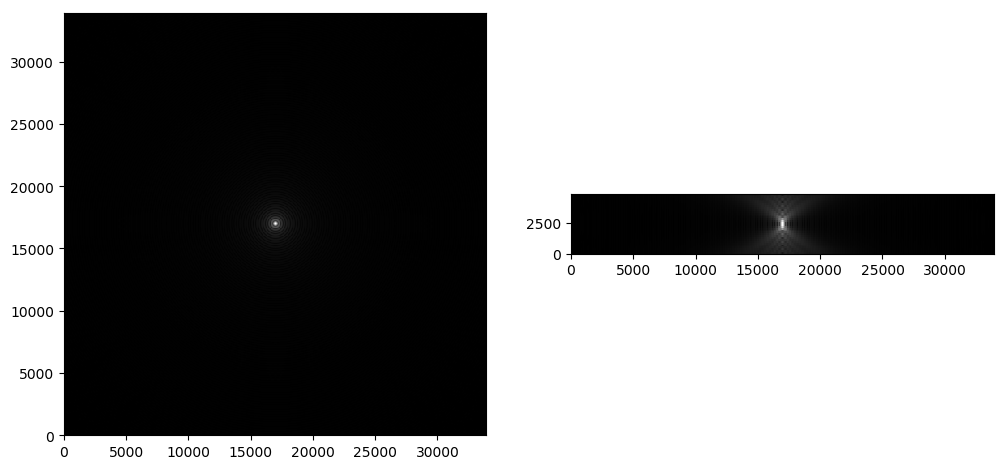

PyObject <matplotlib.image.AxesImage object at 0x7ff3100d06d8>

In [12]:
visualize3d(psf.^(1/3), xystep, zstep)

# Perform deconvolution
Due to the compilation time, the algorithm runs slow at the first run but should run much faster from the second run.

You might also experience GPU memory error on the second run because the GPU memory was not released from the first run. You can try to run it again, which typically resolve the issue if you were able to run it on the first run.

In [15]:
options = ThreeDeconv.DeconvolutionOptions(
    max_iters=150,
    show_trace=true,
    check_every=10
)
reg = 0.01
result = ThreeDeconv.deconvolve(img, psf, γ, σ, reg, options=options);

Clipped voxels: 0.037366693670099434%
Iter     rel_diff      time  
------   ---------   --------
     0         NaN       0.01
    10       0.107       1.74
    20      0.0352       3.48
    30      0.0151       5.23
    40     0.00942       6.97
    50       0.007       8.73
    60     0.00584      10.47
    70     0.00504      12.22
    80     0.00442      13.96
    90     0.00399      15.71
   100     0.00365      17.46
   110     0.00335      19.21
   120     0.00306      20.95
   130     0.00279      22.70
   140     0.00256      24.44
   150     0.00235      26.19
Deconvolution finished.


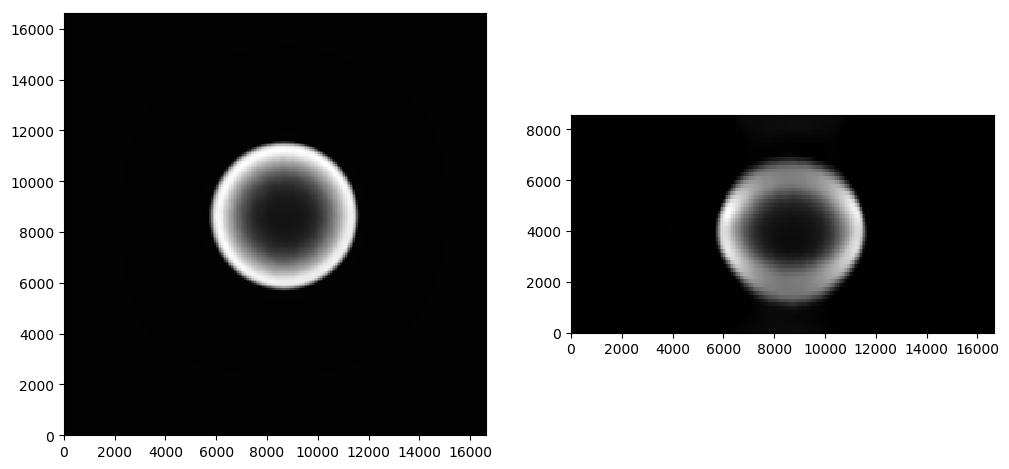

PyObject <matplotlib.image.AxesImage object at 0x7f872e26e940>

In [12]:
visualize3d(result.x, xystep, zstep)

# Save the deconvolved image

In [13]:
imsave("deconvoled.tif", result.x)